In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import Library yang Diperlukan
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

# Cek apakah GPU tersedia (Sangat disarankan menggunakan GPU di Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")

# Konfigurasi Path (SESUAIKAN NAMA FILE ANDA DI SINI)
# Pastikan file 'kucing.jpg' dan 'alam.jpg' ada di folder tersebut.
base_path = '/content/drive/MyDrive/deep learning lanjut/alam dan malaikat'
content_img_path = os.path.join(base_path, '/content/drive/MyDrive/deep learning lanjut/alam dan malaikat/malaikat.png')
style_img_path = os.path.join(base_path, '/content/drive/MyDrive/deep learning lanjut/alam dan malaikat/alam semesta.jfif')

# Cek apakah file ada
if not os.path.exists(content_img_path) or not os.path.exists(style_img_path):
    print(f"ERROR: Pastikan file gambar ada di: {base_path}")
else:
    print("Path file ditemukan.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Menggunakan perangkat: cuda
Path file ditemukan.


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Ukuran tensor gambar: torch.Size([1, 3, 512, 512])


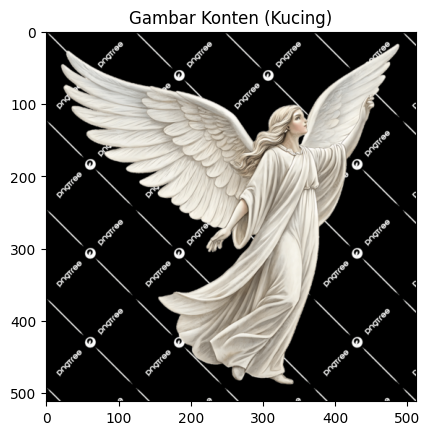

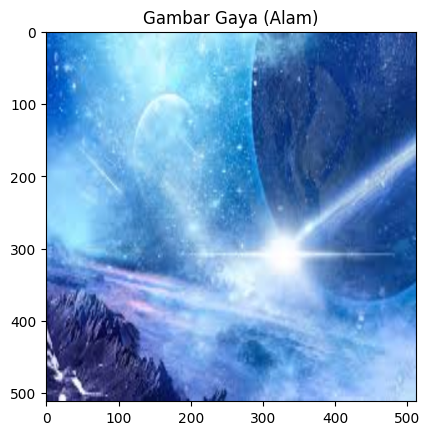

In [2]:
# Ukuran gambar yang diinginkan (semakin kecil semakin cepat, tapi detail berkurang)
imsize = 512 if torch.cuda.is_available() else 128

# Transformasi untuk memproses gambar
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # Ubah ukuran agar seragam
    transforms.ToTensor(), # Ubah ke tensor (0-1)
    # Normalisasi standar untuk model VGG
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    # Tambahkan dimensi batch (C, H, W) -> (1, C, H, W)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Muat gambar konten dan gaya
content_img = image_loader(content_img_path)
style_img = image_loader(style_img_path)

print(f"Ukuran tensor gambar: {content_img.shape}")

# Fungsi untuk menampilkan gambar (perlu denormalisasi agar warnanya benar saat ditampilkan)
unloader = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.ToPILImage()
])

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # clone tensor agar tidak mengubah aslinya
    image = image.squeeze(0)      # hilangkan dimensi batch
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

# Tampilkan gambar input
plt.figure()
imshow(content_img, title='Gambar Konten (Kucing)')
plt.figure()
imshow(style_img, title='Gambar Gaya (Alam)')

In [3]:
# Muat model VGG19 pretrained dan bekukan parameternya (kita tidak melatih VGG)
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

# Fungsi untuk menghitung Gram Matrix (kunci untuk menangkap "Gaya"/tekstur)
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=batch size(=1), b=number of feature maps, (c,d)=dimensions of a f. map
    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # compute the gram product
    # normalisasi dengan membagi jumlah elemen
    return G.div(a * b * c * d)

# Kita membutuhkan fitur dari lapisan tertentu di VGG
# Lapisan ini terbukti bagus untuk memisahkan konten dan gaya
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

class FeatureExtractor(nn.Module):
    def __init__(self, cnn, content_layers, style_layers):
        super(FeatureExtractor, self).__init__()
        self.cnn = cnn
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.selected_layers = set(content_layers + style_layers)

    # Mendapatkan fitur dari lapisan yang dipilih
    def forward(self, x):
        content_features = {}
        style_features = {}

        # Loop melalui lapisan VGG
        idx = 0
        for layer in self.cnn.children():
            if isinstance(layer, nn.Conv2d):
                idx += 1
                name = 'conv_' + str(idx)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_' + str(idx)
                # Trik penting untuk hasil yang lebih halus: gunakan inplace=False
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_' + str(idx)
            else:
                continue # lewati lapisan lain

            x = layer(x)

            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                # Untuk gaya, kita simpan Gram Matrix-nya
                style_features[name] = gram_matrix(x)

        return content_features, style_features

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:04<00:00, 116MB/s]


In [4]:
# --- KONFIGURASI TRAINING ---
# Jumlah langkah optimasi (semakin banyak semakin lama tapi hasil mungkin lebih baik)
steps = 500 # Coba 300 - 1000

# Bobot untuk menyeimbangkan gaya vs konten
# Untuk "Natural", content weight harus cukup tinggi agar bentuk tidak rusak.
style_weight = 1e6    # Seberapa kuat gaya alam diterapkan
content_weight = 1    # Seberapa kuat bentuk kucing dipertahankan

print("Memulai proses Style Transfer...")

# 1. Inisialisasi Ekstraktor Fitur
extractor = FeatureExtractor(vgg, content_layers_default, style_layers_default).to(device)

# 2. Dapatkan target fitur (apa yang ingin kita capai)
# Fitur konten target dari gambar kucing
content_targets, _ = extractor(content_img)
# Fitur gaya target dari gambar alam
_, style_targets = extractor(style_img)

# 3. Gambar Input yang akan dioptimasi
# Kita mulai dari gambar konten asli agar hasilnya lebih natural
input_img = content_img.clone().requires_grad_(True)

# 4. Optimizer (LBFGS biasanya memberikan hasil yang lebih tajam untuk tugas ini)
optimizer = optim.LBFGS([input_img])

run = [0]
while run[0] <= steps:

    def closure():
        # Penting: klip nilai piksel agar tetap dalam rentang tensor yang valid sebelum normalisasi
        with torch.no_grad():
            input_img.clamp_(-2.5, 2.5) # Nilai kira-kira setelah normalisasi VGG

        optimizer.zero_grad()

        # Ekstrak fitur dari gambar input saat ini
        content_features, style_features = extractor(input_img)

        style_loss = 0
        content_loss = 0

        # Hitung Content Loss (MSE antara fitur input dan fitur target kucing)
        for layer in content_layers_default:
            content_loss += torch.mean((content_features[layer] - content_targets[layer])**2)

        # Hitung Style Loss (MSE antara Gram Matrix input dan Gram Matrix alam)
        for layer in style_layers_default:
            style_loss += torch.mean((style_features[layer] - style_targets[layer])**2)

        # Total Loss dengan pembobotan
        total_loss = style_weight * style_loss + content_weight * content_loss

        # Backpropagation
        total_loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step: {run[0]}, Style Loss: {style_loss.item():.4f}, Content Loss: {content_loss.item():.4f}")

        return total_loss

    optimizer.step(closure)

# Klip terakhir kali agar gambar valid
with torch.no_grad():
    input_img.clamp_(-2.5, 2.5)

print("Selesai!")

Memulai proses Style Transfer...
Step: 50, Style Loss: 0.0004, Content Loss: 41.2238
Step: 100, Style Loss: 0.0001, Content Loss: 39.9062
Step: 150, Style Loss: 0.0000, Content Loss: 35.8706
Step: 200, Style Loss: 0.0000, Content Loss: 33.4915
Step: 250, Style Loss: 0.0000, Content Loss: 31.8089
Step: 300, Style Loss: 0.0000, Content Loss: 31.4312
Step: 350, Style Loss: 0.0000, Content Loss: 29.8506
Step: 400, Style Loss: 0.0000, Content Loss: 28.6405
Step: 450, Style Loss: 0.0000, Content Loss: 28.0705
Step: 500, Style Loss: 0.0000, Content Loss: 28.6352
Selesai!


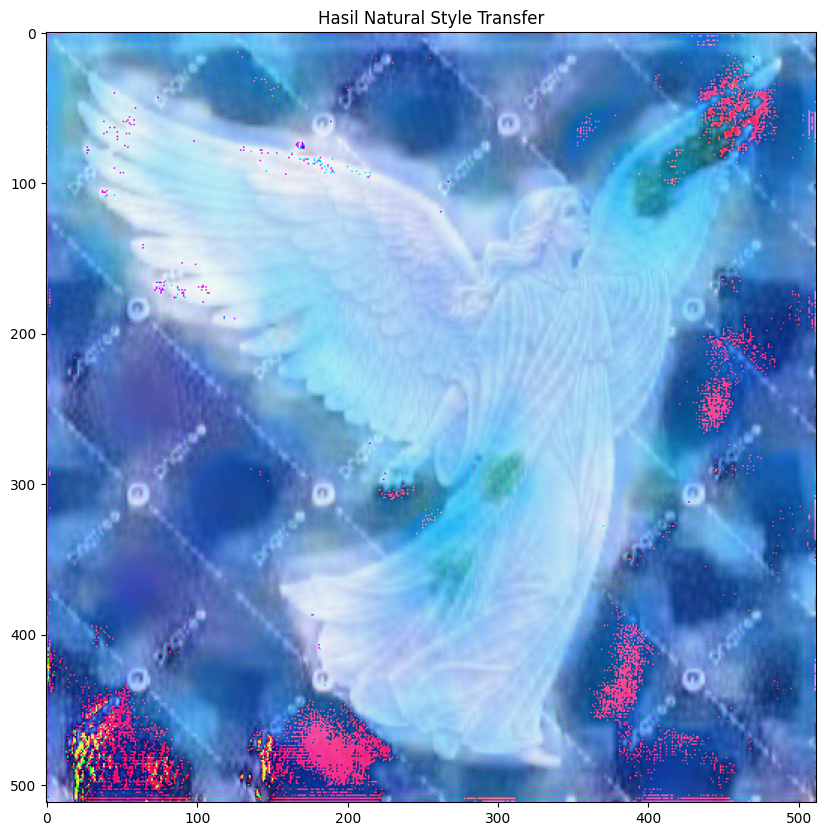

Gambar berhasil disimpan di: /content/drive/MyDrive/deep learning lanjut/alam dan malaikat/hasil_natural_transfer.jpg


In [5]:
# Tampilkan hasil akhir
plt.figure(figsize=(10,10))
imshow(input_img, title='Hasil Natural Style Transfer')
plt.show()

# Simpan hasil ke Google Drive
output_path = os.path.join(base_path, 'hasil_natural_transfer.jpg')
# Kita perlu men-denormalisasi sebelum menyimpan
final_image = unloader(input_img.squeeze(0).cpu().clone())
final_image.save(output_path)
print(f"Gambar berhasil disimpan di: {output_path}")